# **Model**
This dataset presents transactions that occurred in two days, where we have 492 frauds out of 284,807 transactions. The dataset is highly unbalanced, the positive class (frauds) account for 0.172% of all transactions.
If we use this dataframe as the base for our predictive models and analysis we might get a lot of errors and our algorithms will probably overfit since it will "assume" that most transactions are not fraud. But we don't want our model to assume, we want our model to detect patterns that give signs of fraud!

## Setup Environment
Import necessary modules and configure the project path to access source code modules from the src directory.

In [1]:
import sys
import os

project_root = os.path.abspath("..")
sys.path.append(project_root)

## Import Required Libraries
Import NumPy for numerical operations and import visualization and model functions from custom modules.

In [2]:
import numpy as np
from src.visualization import *
from src.models import *

## Load Processed Data
Load the preprocessed dataset from CSV file containing scaled features and target labels.

In [3]:
path_data = '../Data/processed/data_processed.csv'
print("Reading data_processed.csv...")
data = np.genfromtxt(path_data, delimiter=',', skip_header=1, encoding='utf-8')
print("Successful!")
X = data[:, :-1].astype(np.float64)
y = data[:, -1].astype(np.int32)

Reading data_processed.csv...
Successful!
Successful!


## Balance Dataset with Random Sampling
Handle class imbalance by randomly sampling non-fraud transactions to match the number of fraud cases, creating a balanced dataset for fair model training.

In [4]:
rng = np.random.default_rng(42)
fraud_idx = np.where(y == 1)[0]
non_fraud_idx = np.where(y == 0)[0]
rng.shuffle(non_fraud_idx)
sampled_non_fraud = non_fraud_idx[:len(fraud_idx)]

## Create Balanced Dataset
Combine sampled fraud and non-fraud indices, shuffle them, and extract balanced features and labels.

In [5]:
balanced_idx = np.concatenate([fraud_idx, sampled_non_fraud])
rng.shuffle(balanced_idx)
X_bal = X[balanced_idx]
y_bal = y[balanced_idx]

#### Visualize evenly distributed layers

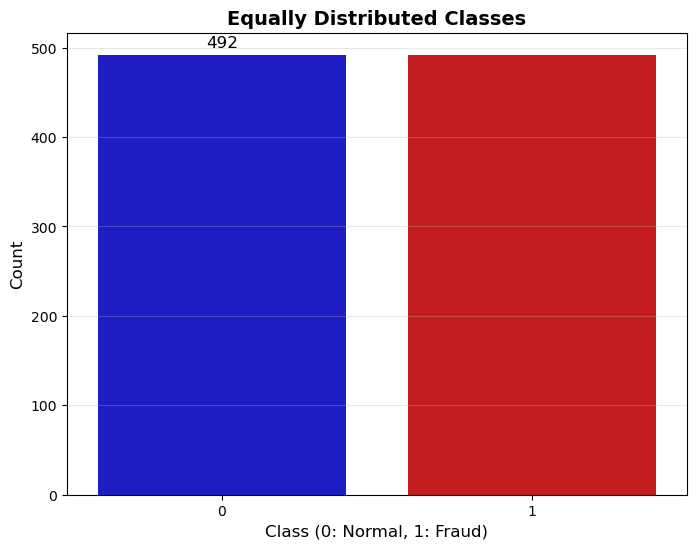

In [6]:
Plot_Class_Distribution(y_bal)

## Cross-Validation with Stratified K-Fold
Perform 5-fold cross-validation on the balanced dataset. For each fold:
1. Normalize training data using train set statistics
2. Train LogisticRegression model with early stopping
3. Calculate AUC-ROC on validation set
4. Store results for evaluation

In [7]:
folds = stratified_kfold_indices(y_bal, n_splits=5)
cv_aucs = []

for fold, (train_idx, val_idx) in enumerate(folds):
    X_tr, X_val = X_bal[train_idx], X_bal[val_idx]
    y_tr, y_val = y_bal[train_idx], y_bal[val_idx]
    
    mean, std = X_tr.mean(axis=0), X_tr.std(axis=0)
    std[std == 0] = 1.0
    X_tr_s = (X_tr - mean) / std
    X_val_s = (X_val - mean) / std
    
    model = LogisticRegressionNumPy(lr=0.05, momentum=0.9, max_epochs=5000, patience=80)
    model.fit(X_tr_s, y_tr, X_val_s, y_val)
    
    proba = model.predict_proba(X_val_s)[:, 1]
    sorted_idx = np.argsort(-proba)
    y_sorted = y_val[sorted_idx]
    tpr = np.cumsum(y_sorted) / y_sorted.sum()
    fpr = np.cumsum(1 - y_sorted) / (len(y_sorted) - y_sorted.sum())
    auc_score = np.trapz(tpr, fpr)
    cv_aucs.append(auc_score)

   Early stopping tại epoch 394
   Early stopping tại epoch 412
   Early stopping tại epoch 460
   Early stopping tại epoch 1534
   Early stopping tại epoch 240


## Train-Test Split
Split balanced dataset into training (80%) and test (20%) sets with fixed random seed for reproducibility.

In [8]:
test_ratio = 0.2
n_test = int(len(X_bal) * test_ratio)
rng = np.random.default_rng(42)
idx = np.arange(len(X_bal))
rng.shuffle(idx)

test_idx = idx[:n_test]
train_idx = idx[n_test:]

X_train_final = X_bal[train_idx]
y_train_final = y_bal[train_idx]
X_test_final  = X_bal[test_idx]
y_test_final  = y_bal[test_idx]

## Calculate Normalization Statistics
Compute mean and standard deviation from training set to normalize both training and test data consistently.

In [9]:
mean_train = X_train_final.mean(axis=0)
std_train  = X_train_final.std(axis=0)
std_train[std_train == 0] = 1.0

## Normalize Train and Test Data
Apply Z-score normalization using training set statistics to both training and test sets.

In [10]:
X_train_norm = (X_train_final - mean_train) / std_train
X_test_norm  = (X_test_final  - mean_train) / std_train

## Train Final Model
Train the final Logistic Regression model on normalized training data with optimized hyperparameters (learning rate, momentum, max epochs, early stopping patience).

In [11]:
final_model = LogisticRegressionNumPy(lr=0.05, momentum=0.9, max_epochs=5000, patience=80)
final_model.fit(X_train_norm, y_train_final)

## Generate Predictions
Generate probability predictions on test set and convert to binary predictions using 0.5 threshold.

In [12]:
y_proba = final_model.predict_proba(X_test_norm)[:, 1]
y_pred  = (y_proba >= 0.5).astype(np.int32)

## Calculate AUC-ROC Score
Compute AUC-ROC metric by calculating true positive rate (TPR) and false positive rate (FPR) across all thresholds, then integrating the ROC curve.

In [13]:
sorted_idx = np.argsort(-y_proba)
y_sorted = y_test_final[sorted_idx]
tpr = np.cumsum(y_sorted) / y_sorted.sum()
fpr = np.cumsum(1 - y_sorted) / (len(y_sorted) - y_sorted.sum())
test_auc = np.trapz(tpr, fpr)

## Evaluate Model Performance
Calculate and display comprehensive evaluation metrics:
- **TP, TN, FP, FN**: Confusion matrix components
- **Accuracy**: Overall correctness rate
- **Precision**: Fraction of predicted frauds that are actual frauds
- **Recall**: Fraction of actual frauds correctly detected
- **F1-Score**: Harmonic mean of precision and recall

In [14]:
TP = np.sum((y_test_final == 1) & (y_pred == 1))
TN = np.sum((y_test_final == 0) & (y_pred == 0))
FP = np.sum((y_test_final == 0) & (y_pred == 1))
FN = np.sum((y_test_final == 1) & (y_pred == 0))

accuracy  = (TP + TN) / len(y_test_final)
precision = TP / (TP + FP) if (TP + FP) > 0 else 0.0
recall    = TP / (TP + FN) if (TP + FN) > 0 else 0.0
f1        = 2 * precision * recall / (precision + recall) if (precision + recall) > 0 else 0.0

print(f"\nFINAL TEST RESULTS:")
print(f"AUC-ROC     : {test_auc:.5f}")
print(f"Accuracy    : {accuracy:.5f}")
print(f"Precision   : {precision:.5f}")
print(f"Recall      : {recall:.5f}")
print(f"F1-Score    : {f1:.5f}")


FINAL TEST RESULTS:
AUC-ROC     : 0.97683
Accuracy    : 0.94388
Precision   : 0.96117
Recall      : 0.93396
F1-Score    : 0.94737


## Visualize Evaluation Results
Plot Training Loss, ROC curve, and Precision-Recall Curve visualizations to assess model performance comprehensively.

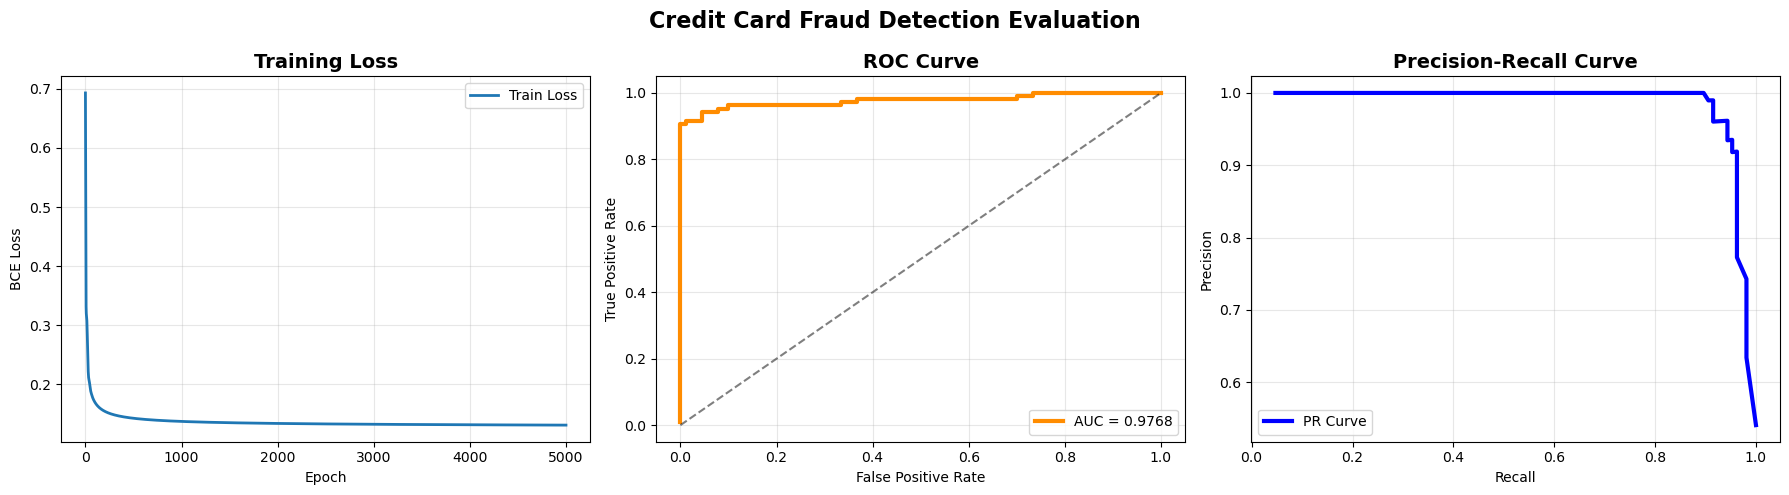

In [15]:
Plot_Evaluation(final_model, y_test_final, y_proba)

## Clean Up Memory
Delete large intermediate arrays to free up memory after modeling is complete.

In [16]:
del data, X , y